# (Legacy) LSTM_fixed.ipynb

此 notebook 的通用组件（数据/特征/序列化/训练/回测）已模块化到 `fyp_trading/`。

- 建议：如需复现实验，请改用模块化脚本；此处仅保留作历史参考。



In [ ]:
# %% [markdown]
# # Fixed-window LSTM (PyTorch) for time-series modeling
#
# This notebook converts the previous walk-forward (expanding) training scheme
# into a strict fixed-window scheme:
# - For each fold:
#   - Train on the most recent `train_window` sequences,
#   - Validate on the subsequent `val_size` sequences,
#   - Test on the subsequent `test_size` sequences.
# - Step forward by `step_size` (default = `test_size`) for the next fold.
#
# All other components (feature engineering, sequence building, LSTM models,
# standardization only using the training set, evaluation, visualization, OOF)
# remain the same in spirit—only the CV windowing logic is changed to fixed-length.

In [ ]:
# %%
import warnings
warnings.filterwarnings("ignore")

import os, sys, math, random, copy
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid') if 'seaborn-v0_8-whitegrid' in plt.style.available else plt.style.use('ggplot')
sns.set_palette("Set2")

import yfinance as yf

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score
)

from typing import Dict, List, Tuple

# IPython display (fallback to print if not in notebook)
try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device and seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Make CuDNN more reproducible (slightly slower)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Device:", device)

In [ ]:
# %% [markdown]
# ## 1) Data fetching
# - Ticker: 2800.HK
# - Period: 2 years
# - Interval: 1d

In [ ]:
# %%
def fetch_prices(ticker="2800.HK", period="1y", interval="1d") -> pd.DataFrame:
    tk = yf.Ticker(ticker)
    df = tk.history(period=period, interval=interval, auto_adjust=True)
    if df is None or df.empty:
        end = pd.Timestamp.today().normalize()
        start = end - pd.Timedelta(days=3*370)
        df = tk.history(start=start, end=end, interval=interval, auto_adjust=True)
    if df is None or df.empty:
        raise RuntimeError(f"Cannot fetch data for {ticker}")
    df.index = pd.to_datetime(df.index).tz_localize(None)
    return df[["Open", "High", "Low", "Close", "Volume"]].copy()

ticker = "2800.HK"
df_raw = fetch_prices(ticker=ticker, period="1y", interval="1d")
print(f"Data range: {df_raw.index.min().date()} to {df_raw.index.max().date()}")
print(f"Total samples: {len(df_raw)}")
display(df_raw.tail())

In [ ]:
# %% [markdown]
# ## 2) Feature engineering (aligned with prior logic, no leakage)
# - Label: next_return (default log return), classification target_up = (next_return > 0)
# - Features: OHLCV-derived, volatility/MAs/RSI/MACD/Bollinger/volume/calendar/lagged returns
# - Note: We keep the original EMA-based RSI/MACD and shift(1) usage to avoid leakage,
#         and do not alter other logics beyond the CV windowing scheme.

In [ ]:
# %%
def calculate_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean().replace(0, np.nan)
    rs = roll_up / roll_down
    return 100 - (100 / (1 + rs))

def calculate_macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def build_features_and_labels(df: pd.DataFrame,
                              horizon: int = 1,
                              use_log_return: bool = True):
    """
    horizon: prediction step (days), default 1
    use_log_return: True for log returns, False for simple returns
    """
    close = df["Close"].copy()
    features = pd.DataFrame(index=df.index)

    # Price changes (historical)
    features["ret_1d"]  = close.pct_change(1)
    features["ret_2d"]  = close.pct_change(2)
    features["ret_5d"]  = close.pct_change(5)
    features["ret_10d"] = close.pct_change(10)

    # Realized volatility
    features["vol_5d"]  = features["ret_1d"].rolling(5).std()
    features["vol_10d"] = features["ret_1d"].rolling(10).std()
    features["vol_20d"] = features["ret_1d"].rolling(20).std()

    # Moving averages and relative positions
    sma_5  = close.rolling(5).mean()
    sma_10 = close.rolling(10).mean()
    sma_20 = close.rolling(20).mean()
    sma_50 = close.rolling(50).mean()

    # Use close.shift(1) when comparing to MAs to avoid leakage
    features["close_to_sma5"]  = close.shift(1) / sma_5 - 1
    features["close_to_sma10"] = close.shift(1) / sma_10 - 1
    features["close_to_sma20"] = close.shift(1) / sma_20 - 1
    features["sma5_sma10"]     = sma_5 / sma_10 - 1
    features["sma10_sma20"]    = sma_10 / sma_20 - 1

    # Technical indicators (use past info)
    features["rsi_14"] = calculate_rsi(close.shift(1), 14)
    macd_line, signal_line, histogram = calculate_macd(close.shift(1))
    features["macd"]        = macd_line
    features["macd_signal"] = signal_line
    features["macd_hist"]   = histogram

    # Bollinger band relative positions
    bb_period = 20
    bb_std = close.rolling(bb_period).std()
    bb_mean = close.rolling(bb_period).mean()
    features["bb_upper"] = (bb_mean + 2 * bb_std - close.shift(1)) / close.shift(1)
    features["bb_lower"] = (close.shift(1) - (bb_mean - 2 * bb_std)) / close.shift(1)

    # Volume features
    if "Volume" in df.columns:
        features["volume_ratio"]  = df["Volume"] / df["Volume"].rolling(20).mean()
        features["volume_change"] = df["Volume"].pct_change()

    # Calendar features
    features["day_of_week"] = df.index.dayofweek
    features["month"]       = df.index.month
    features["quarter"]     = df.index.quarter

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        features[f"ret_lag_{lag}"] = features["ret_1d"].shift(lag)

    # Targets
    if use_log_return:
        next_ret = np.log(close.shift(-horizon) / close)
    else:
        next_ret = close.pct_change(horizon).shift(-horizon)

    target_up = (next_ret > 0).astype(int)

    # Clean
    features = features.replace([np.inf, -np.inf], np.nan)
    data = features.copy()
    data["next_return"] = next_ret
    data["target_up"]   = target_up

    data = data.dropna().copy()
    feature_cols = [c for c in data.columns if c not in ["next_return", "target_up"]]
    return data, feature_cols

feat_df, feature_cols = build_features_and_labels(df_raw, horizon=1, use_log_return=True)
print(f"Samples after cleaning: {len(feat_df)}, Features: {len(feature_cols)}")
display(feat_df.tail())

In [ ]:
# %% [markdown]
# ## 3) Turn features into fixed-length sequence windows (lookback)
# - X: [num_samples, lookback, num_features]
# - y: aligned to the end date of each window (sequence label)

In [ ]:
# %%
def make_sequences(feat_df: pd.DataFrame,
                   feature_cols: List[str],
                   lookback: int = 60) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DatetimeIndex]:
    X_2d = feat_df[feature_cols].astype(float).values
    y_cls_all = feat_df["target_up"].astype(int).values
    y_reg_all = feat_df["next_return"].astype(float).values
    dates = feat_df.index

    N = len(feat_df)
    F = len(feature_cols)
    if N < lookback:
        raise ValueError(f"Too few samples: N={N} < lookback={lookback}")

    X_list, y_cls_list, y_reg_list, idx_list = [], [], [], []
    for end in range(lookback - 1, N):
        start = end - lookback + 1
        X_list.append(X_2d[start:end+1])
        y_cls_list.append(y_cls_all[end])
        y_reg_list.append(y_reg_all[end])
        idx_list.append(dates[end])

    X_seq = np.asarray(X_list, dtype=np.float32)
    y_cls = np.asarray(y_cls_list, dtype=np.int64)
    y_reg = np.asarray(y_reg_list, dtype=np.float32)
    seq_index = pd.DatetimeIndex(idx_list)
    return X_seq, y_cls, y_reg, seq_index

LOOKBACK = 14
X_seq_all, y_cls_all, y_reg_all, seq_index = make_sequences(feat_df, feature_cols, lookback=LOOKBACK)
print("X_seq_all:", X_seq_all.shape, "y_cls_all:", y_cls_all.shape, "y_reg_all:", y_reg_all.shape)
print("First/Last seq date:", seq_index[0].date(), "->", seq_index[-1].date())

In [ ]:
# %% [markdown]
# ## 4) Per-feature standardization for 3D sequences (fit on train only)

In [ ]:
# %%
def fit_scaler_3d(X_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    X_train: (N_train, T, F)
    Returns per-feature mean/std (shape (F,))
    """
    assert X_train.ndim == 3
    N, T, F = X_train.shape
    flat = X_train.reshape(-1, F)
    mean = flat.mean(axis=0)
    std = flat.std(axis=0)
    std = np.where(std < 1e-12, 1e-12, std)
    return mean.astype(np.float32), std.astype(np.float32)

def transform_3d(X: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (X - mean[None, None, :]) / std[None, None, :]

In [ ]:
# %% [markdown]
# ## 5) LSTM models (PyTorch)

In [ ]:
# %%
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, bidirectional=False, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):                       # x: [B,T,F]
        out, _ = self.lstm(x)                   # [B,T,H]
        h = out[:, -1, :]
        h = self.dropout(h)
        h = self.act(self.fc1(h))
        logit = self.out(h)
        return logit

class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size=32, num_layers=1, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden_size, 1)  # continuous output
    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        h = self.dropout(h)
        h = self.act(self.fc1(h))
        y = self.out(h)
        return y

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TrainConfig:
    def __init__(self, epochs=200, batch_size=32, patience=20,
                 lr=1e-3, weight_decay=1e-4, lr_factor=0.5, lr_patience=10, lr_min=1e-5,
                 grad_clip=1.0, verbose=False):
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.lr = lr
        self.weight_decay = weight_decay
        self.lr_factor = lr_factor
        self.lr_patience = lr_patience
        self.lr_min = lr_min
        self.grad_clip = grad_clip
        self.verbose = verbose

CFG = TrainConfig(epochs=200, batch_size=32, patience=20,
                  lr=1e-3, weight_decay=1e-4, lr_factor=0.5, lr_patience=10, lr_min=1e-5,
                  grad_clip=1.0, verbose=False)

def make_loader(X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool) -> DataLoader:
    # Convert y to (N, 1) float32 for both classification and regression
    if y.ndim == 1:
        y = y[:, None]
    X_t = torch.from_numpy(X.astype(np.float32))
    y_t = torch.from_numpy(y.astype(np.float32))
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=0, pin_memory=torch.cuda.is_available())

def train_torch_model(model: nn.Module,
                      train_loader: DataLoader,
                      val_loader: DataLoader,
                      criterion: nn.Module,
                      cfg: TrainConfig) -> Tuple[nn.Module, Dict[str, list]]:
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    # Compatible ReduceLROnPlateau across versions
    try:
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min',
            factor=cfg.lr_factor, patience=cfg.lr_patience,
            min_lr=cfg.lr_min
        )
    except TypeError:
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min',
            factor=cfg.lr_factor, patience=cfg.lr_patience
        )

    best_state = copy.deepcopy(model.state_dict())
    best_val = float('inf')
    no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, cfg.epochs + 1):
        # ---- Train ----
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # ---- Val ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if cfg.verbose and (epoch % 10 == 0 or epoch == 1):
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f} | lr {cur_lr:.2e}")

        # ---- Early stopping ----
        if val_loss + 1e-12 < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                if cfg.verbose:
                    print(f"Early stop at epoch {epoch}, best_val={best_val:.6f}")
                break

    model.load_state_dict(best_state)
    return model, history

def predict_torch(model: nn.Module, X: np.ndarray, batch_size: int = 256) -> np.ndarray:
    model = model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size].astype(np.float32)).to(device)
            out = model(xb)
            preds.append(out.detach().cpu().numpy())
    preds = np.concatenate(preds, axis=0)  # (N, 1)
    return preds.ravel()

In [ ]:
# %% [markdown]
# ## 6) One-fold train wrappers and evaluators

In [ ]:
# %%
def train_lstm_cls_reg(X_train, y_cls_train, y_reg_train,
                       X_val, y_cls_val, y_reg_val,
                       cfg: TrainConfig):
    input_size = X_train.shape[-1]
    clf = LSTMClassifier(input_size=input_size, hidden_size=32, dropout=0.2)
    reg = LSTMRegressor(input_size=input_size, hidden_size=32, dropout=0.2)

    # DataLoaders
    train_loader_cls = make_loader(X_train, y_cls_train.astype(np.float32), cfg.batch_size, shuffle=True)
    val_loader_cls   = make_loader(X_val,   y_cls_val.astype(np.float32),   cfg.batch_size, shuffle=False)
    train_loader_reg = make_loader(X_train, y_reg_train.astype(np.float32), cfg.batch_size, shuffle=True)
    val_loader_reg   = make_loader(X_val,   y_reg_val.astype(np.float32),   cfg.batch_size, shuffle=False)

    # Losses
    crit_cls = nn.BCEWithLogitsLoss()
    crit_reg = nn.SmoothL1Loss()  # Huber

    # Train
    clf, _ = train_torch_model(clf, train_loader_cls, val_loader_cls, crit_cls, cfg)
    reg, _ = train_torch_model(reg, train_loader_reg, val_loader_reg, crit_reg, cfg)

    return clf, reg

def eval_fold_torch(clf, reg, X_test, y_cls_test, y_reg_test) -> Dict[str, float]:
    # Classification probability = sigmoid(logit)
    logits = predict_torch(clf, X_test, batch_size=256)
    proba = 1.0 / (1.0 + np.exp(-logits))
    y_pred_cls = (proba >= 0.5).astype(int)

    acc  = accuracy_score(y_cls_test, y_pred_cls)
    try:
        bacc = balanced_accuracy_score(y_cls_test, y_pred_cls)
    except Exception:
        bacc = np.nan
    try:
        auc = roc_auc_score(y_cls_test, proba)
    except Exception:
        auc = np.nan

    # Regression
    y_pred_reg = predict_torch(reg, X_test, batch_size=256)
    reg_mae = mean_absolute_error(y_reg_test, y_pred_reg)
    reg_rmse = math.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
    try:
        reg_r2 = r2_score(y_reg_test, y_pred_reg)
    except Exception:
        reg_r2 = np.nan
    dir_acc = (np.sign(y_reg_test) == np.sign(y_pred_reg)).mean()

    return {
        "cls_acc": acc, "cls_bacc": bacc, "cls_auc": auc,
        "reg_mae": reg_mae, "reg_rmse": reg_rmse, "reg_r2": reg_r2,
        "reg_dir_acc": dir_acc
    }

In [ ]:
# %% [markdown]
# ## 7) Fixed-window CV (LSTM, PyTorch)
# - Fixed-length train window (`train_window`), followed by `val_size`, then `test_size`.
# - Standardize using only the training split in each fold.
# - Step forward by `step_size` (default = `test_size`).

In [ ]:
# %%
def fixed_window_cv_lstm_torch(X_seq_all: np.ndarray,
                               y_cls_all: np.ndarray,
                               y_reg_all: np.ndarray,
                               seq_index: pd.DatetimeIndex,
                               test_size: int = 14,
                               train_window: int = 400,
                               val_size: int = 20,
                               step_size: int = None,
                               cfg: TrainConfig = CFG) -> pd.DataFrame:
    if step_size is None:
        step_size = test_size

    metrics = []
    N = len(X_seq_all)
    # First possible test_start index after having train_window + val_size available
    start_index = train_window + val_size
    fold_id = 0

    for test_start in range(start_index, N - test_size + 1, step_size):
        train_end = test_start
        val_start = train_end - val_size
        train_start = val_start - train_window
        test_end = test_start + test_size

        if train_start < 0:
            continue

        X_train = X_seq_all[train_start: val_start]
        y_cls_train = y_cls_all[train_start: val_start]
        y_reg_train = y_reg_all[train_start: val_start]

        X_val = X_seq_all[val_start: train_end]
        y_cls_val = y_cls_all[val_start: train_end]
        y_reg_val = y_reg_all[val_start: train_end]

        X_test = X_seq_all[test_start: test_end]
        y_cls_test = y_cls_all[test_start: test_end]
        y_reg_test = y_reg_all[test_start: test_end]

        # Standardize using training only
        mean, std = fit_scaler_3d(X_train)
        X_train_sc = transform_3d(X_train, mean, std)
        X_val_sc   = transform_3d(X_val,   mean, std)
        X_test_sc  = transform_3d(X_test,  mean, std)

        # Train
        clf, reg = train_lstm_cls_reg(X_train_sc, y_cls_train, y_reg_train,
                                      X_val_sc,   y_cls_val,   y_reg_val,
                                      cfg)

        # Evaluate
        fold_metrics = eval_fold_torch(clf, reg, X_test_sc, y_cls_test, y_reg_test)
        fold_metrics["fold"] = fold_id
        fold_metrics["train_size"] = len(X_train_sc)
        fold_metrics["val_size"] = len(X_val_sc)
        fold_metrics["test_size"] = len(X_test_sc)
        fold_metrics["test_start"] = seq_index[test_start]
        fold_metrics["test_end"] = seq_index[test_end - 1]
        metrics.append(fold_metrics)

        fold_id += 1

        # Free memory
        del clf, reg
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return pd.DataFrame(metrics)

In [ ]:
# %% [markdown]
# ## 8) Run fixed-window CV and summarize metrics

In [ ]:
# %%
cv_results = fixed_window_cv_lstm_torch(
    X_seq_all, y_cls_all, y_reg_all, seq_index,
    test_size=7, train_window=150, val_size=10, step_size=7,
    cfg=CFG
)

print(f"Folds: {len(cv_results)}")
display(cv_results[["fold","test_start","test_end","train_size","val_size","test_size"]].head())

def summarize_metrics(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    return df[cols].agg(['mean','std','min','max'])

print("\n=== Per-fold metrics (head) ===")
display(cv_results.head())

print("\n=== Summary (Classification) ===")
display(summarize_metrics(cv_results, ["cls_acc", "cls_bacc", "cls_auc"]))

print("\n=== Summary (Regression on next_return) ===")
display(summarize_metrics(cv_results, ["reg_mae", "reg_rmse", "reg_r2", "reg_dir_acc"]))

# Naive baselines over the sequence sample
naive_mae = np.abs(y_reg_all).mean()
naive_dir_acc = max((y_reg_all > 0).mean(), (y_reg_all <= 0).mean())
print("\n=== Naive baselines over sequence sample ===")
print(f"Regression MAE baseline (predict 0): {naive_mae:.6f}")
print(f"Direction baseline (majority sign): {naive_dir_acc:.3f}")

In [ ]:
# %% [markdown]
# ## 9) Visualization: pick a fold (last/best_auc/best_dir) and plot
# - Panel 1: next_return actual vs predicted (test window)
# - Panel 2: reconstructed price paths (from the previous close), assuming log returns

In [ ]:
# %%
def pick_fold_index(cv_df, mode='last'):
    if len(cv_df) == 0:
        raise ValueError("cv_results is empty, run CV first.")
    if mode == 'last':
        return int(cv_df.iloc[-1]['fold'])
    elif mode == 'best_auc':
        idx = cv_df['cls_auc'].idxmax()
        return int(cv_df.loc[idx, 'fold'])
    elif mode == 'best_dir':
        idx = cv_df['reg_dir_acc'].idxmax()
        return int(cv_df.loc[idx, 'fold'])
    else:
        raise ValueError("mode must be 'last' / 'best_auc' / 'best_dir'")

def reconstruct_price_path(start_price: float, returns: np.ndarray, assume_log_return=True) -> np.ndarray:
    if assume_log_return:
        path = start_price * np.exp(np.cumsum(returns))
    else:
        path = start_price * np.cumprod(1.0 + returns)
    return path

def plot_fold_predictions_lstm_fixed(feat_df, feature_cols, df_raw,
                                     X_seq_all, y_cls_all, y_reg_all, seq_index,
                                     cv_results: pd.DataFrame,
                                     fold_to_plot='last', assume_log_return=True,
                                     cfg: TrainConfig = CFG):
    # Choose fold
    fold_idx = pick_fold_index(cv_results, mode=fold_to_plot)
    row = cv_results[cv_results['fold'] == fold_idx].iloc[0]
    test_start_date = row['test_start']
    test_end_date = row['test_end']

    # Map dates to positional indices on seq_index
    all_dates = seq_index
    test_start = all_dates.get_loc(test_start_date)
    test_end = all_dates.get_loc(test_end_date) + 1  # right-open

    # Reconstruct train/val positions from sizes
    train_size = int(row['train_size'])
    val_size = int(row['val_size'])
    train_end = test_start
    val_start = train_end - val_size
    train_start = val_start - train_size

    if train_start < 0:
        raise ValueError("Not enough history to reconstruct this fold windows.")

    # Slice arrays
    X_train = X_seq_all[train_start: val_start]
    y_cls_train = y_cls_all[train_start: val_start]
    y_reg_train = y_reg_all[train_start: val_start]

    X_val = X_seq_all[val_start: train_end]
    y_cls_val = y_cls_all[val_start: train_end]
    y_reg_val = y_reg_all[val_start: train_end]

    X_test = X_seq_all[test_start: test_end]
    y_cls_test = y_cls_all[test_start: test_end]
    y_reg_test = y_reg_all[test_start: test_end]
    test_dates = all_dates[test_start: test_end]

    # Standardize using training only
    mean, std = fit_scaler_3d(X_train)
    X_train_sc = transform_3d(X_train, mean, std)
    X_val_sc   = transform_3d(X_val,   mean, std)
    X_test_sc  = transform_3d(X_test,  mean, std)

    # Train
    clf, reg = train_lstm_cls_reg(X_train_sc, y_cls_train, y_reg_train,
                                  X_val_sc,   y_cls_val,   y_reg_val,
                                  cfg)

    # Predict
    logits = predict_torch(clf, X_test_sc, batch_size=256)
    proba = 1.0 / (1.0 + np.exp(-logits))
    y_pred_cls = (proba >= 0.5).astype(int)
    y_pred_reg = predict_torch(reg, X_test_sc, batch_size=256)

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax1, ax2 = axes

    # Panel 1: next_return
    ax1.plot(test_dates, y_reg_test, label='Actual next_return', color='tab:blue')
    ax1.plot(test_dates, y_pred_reg, label='Predicted next_return', color='tab:orange', alpha=0.8)
    ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_title(f'Fold {fold_idx}: next_return - Actual vs Predicted (LSTM - PyTorch)')
    ax1.set_ylabel('Return')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Panel 2: price path reconstruction (from previous close)
    feat_index = feat_df.index
    close_aligned = df_raw.loc[feat_index, 'Close']

    pos_in_feat = feat_index.get_loc(test_dates[0])
    if pos_in_feat - 1 >= 0:
        start_close = float(close_aligned.iloc[pos_in_feat - 1])
        actual_price_path = reconstruct_price_path(start_close, y_reg_test, assume_log_return)
        pred_price_path   = reconstruct_price_path(start_close, y_pred_reg, assume_log_return)
        price_index = [feat_index[pos_in_feat - 1]] + list(test_dates)
        ax2.plot(price_index, [start_close] + list(actual_price_path), label='Actual price (reconstructed)', color='tab:green')
        ax2.plot(price_index, [start_close] + list(pred_price_path), label='Predicted price (reconstructed)', color='tab:red', alpha=0.8)
        ax2.set_title(f'Fold {fold_idx}: Price path (from previous close)')
        ax2.set_ylabel('Price')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.set_visible(False)

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

    # Metrics
    acc  = accuracy_score(y_cls_test, y_pred_cls)
    bacc = balanced_accuracy_score(y_cls_test, y_pred_cls)
    try:
        auc = roc_auc_score(y_cls_test, proba)
    except Exception:
        auc = np.nan
    dir_acc = (np.sign(y_reg_test) == np.sign(y_pred_reg)).mean()
    print(f"Fold {fold_idx} metrics:")
    print(f"  Classification - Acc: {acc:.3f}, BalancedAcc: {bacc:.3f}, AUC: {auc:.3f}")
    print(f"  Regression - MAE: {mean_absolute_error(y_reg_test, y_pred_reg):.6f}, "
          f"R2: {r2_score(y_reg_test, y_pred_reg):.6f}, "
          f"DirAcc: {dir_acc:.3f}")

# Plot the last fold by default
plot_fold_predictions_lstm_fixed(
    feat_df=feat_df,
    feature_cols=feature_cols,
    df_raw=df_raw,
    X_seq_all=X_seq_all, y_cls_all=y_cls_all, y_reg_all=y_reg_all, seq_index=seq_index,
    cv_results=cv_results,
    fold_to_plot='last',   # 'last' / 'best_auc' / 'best_dir'
    assume_log_return=True,
    cfg=CFG
)

In [ ]:
# %% [markdown]
# ## 10) OOF (out-of-fold) classification for fixed-window CV
# - Generate OOF probabilities across all folds using fixed windows.
# - Each fold re-standardizes on its training split.

In [ ]:
# %%
def oof_fixed_window_lstm_torch(X_seq_all, y_cls_all, seq_index,
                                test_size=7, train_window=252, val_size=20, step_size=None,
                                cfg: TrainConfig = CFG):
    if step_size is None:
        step_size = test_size

    N = len(X_seq_all)
    start_index = train_window + val_size

    oof_true, oof_proba, oof_pred = [], [], []
    fold_id = 0

    for test_start in range(start_index, N - test_size + 1, step_size):
        train_end = test_start
        val_start = train_end - val_size
        train_start = val_start - train_window
        test_end = test_start + test_size
        if train_start < 0:
            continue

        X_train = X_seq_all[train_start: val_start]
        y_train_cls = y_cls_all[train_start: val_start]
        X_val = X_seq_all[val_start: train_end]
        y_val_cls = y_cls_all[val_start: train_end]
        X_test = X_seq_all[test_start: test_end]
        y_test_cls = y_cls_all[test_start: test_end]

        # Standardize
        mean, std = fit_scaler_3d(X_train)
        X_train_sc = transform_3d(X_train, mean, std)
        X_val_sc   = transform_3d(X_val,   mean, std)
        X_test_sc  = transform_3d(X_test,  mean, std)

        # Train classifier only
        input_size = X_train_sc.shape[-1]
        clf = LSTMClassifier(input_size=input_size, hidden_size=32, dropout=0.2)
        crit_cls = nn.BCEWithLogitsLoss()
        train_loader_cls = make_loader(X_train_sc, y_train_cls.astype(np.float32), cfg.batch_size, shuffle=True)
        val_loader_cls   = make_loader(X_val_sc,   y_val_cls.astype(np.float32),   cfg.batch_size, shuffle=False)
        clf, _ = train_torch_model(clf, train_loader_cls, val_loader_cls, crit_cls, cfg)

        logits = predict_torch(clf, X_test_sc, batch_size=256)
        proba = 1.0 / (1.0 + np.exp(-logits))
        pred = (proba >= 0.5).astype(int)

        oof_true.append(y_test_cls)
        oof_proba.append(proba)
        oof_pred.append(pred)

        fold_id += 1
        del clf
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    y_true = np.concatenate(oof_true) if len(oof_true) else np.array([])
    y_proba = np.concatenate(oof_proba) if len(oof_proba) else np.array([])
    y_pred = np.concatenate(oof_pred) if len(oof_pred) else np.array([])
    return y_true, y_proba, y_pred

y_true, y_proba, y_pred = oof_fixed_window_lstm_torch(
    X_seq_all, y_cls_all, seq_index,
    test_size=7, train_window=252, val_size=20, step_size=7,
    cfg=CFG
)

if len(y_true):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_proba)
    except Exception:
        auc = np.nan

    print(f"OOF Accuracy={acc:.3f}, BalancedAcc={bacc:.3f}, AUC={auc:.3f}, N={len(y_true)}")

    # Approx 95% CI (Wilson-like normal approx)
    from math import sqrt
    n = len(y_true)
    phat = acc
    z = 1.96
    half = z*sqrt(phat*(1-phat)/n)
    print(f"Acc 95% CI (approx): [{phat - half:.3f}, {phat + half:.3f}]")
else:
    print("OOF not generated (insufficient samples or parameter settings).")

Device: cpu
数据范围: 2024-10-07 ~ 2025-10-06, 共 246 根K线


,Open,High,Low,Close,Volume
Date,,,,,
2025-09-26,26.980000,27.059999,26.719999,26.780001,565463647
2025-09-29,27.000000,27.340000,26.980000,27.240000,698376064
2025-09-30,27.280001,27.559999,27.200001,27.520000,383166715
2025-10-03,27.879999,27.920000,27.600000,27.780001,164529440
2025-10-06,27.700001,27.799999,27.520000,27.620001,230855946


清洗后样本数: 222, 特征数: 28


,ret_1d,ret_2d,ret_5d,ret_10d,vol_5d,vol_10d,vol_20d,close_to_sma5,close_to_sma10,close_to_sma20,...,volume_change,day_of_week,month,quarter,ret_lag_1,ret_lag_2,ret_lag_3,ret_lag_5,ret_lag_10,next_return
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-25,-0.001472,0.012687,-0.001472,0.015719,0.008895,0.009729,0.009874,0.004583,0.002508,0.020462,...,0.564963,3,9,3,0.014179,-0.005935,-0.008824,-0.012355,-0.002985,-0.013353
2025-09-26,-0.013265,-0.014717,-0.015441,-0.008148,0.010551,0.010208,0.010523,0.006229,0.001846,0.016746,...,0.016764,4,9,3,-0.001472,0.014179,-0.005935,0.000736,0.010479,0.017031
2025-09-29,0.017177,0.003685,0.010386,0.005908,0.013101,0.011670,0.010187,-0.009176,-0.012027,0.001234,...,0.235050,0,9,3,-0.013265,-0.001472,0.014179,-0.008824,0.002963,0.010227
2025-09-30,0.010279,0.027633,0.026866,0.016999,0.012601,0.012039,0.010218,0.002503,0.003241,0.015622,...,-0.451346,1,9,3,0.017177,-0.013265,-0.001472,-0.005935,-0.000739,0.009403
2025-10-03,0.009448,0.019824,0.022075,0.009448,0.011935,0.011183,0.010130,0.008354,0.012584,0.022478,...,-0.570606,4,10,4,0.010279,0.017177,-0.013265,0.014179,0.016999,-0.005776


阈值搜索结果（按准确率排序）:


,threshold,mean_acc,std_acc,mean_bacc,mean_macro_f1,folds
0,0.0180,0.938776,0.070696,0.785714,0.769231,7
1,0.0167,0.897959,0.064536,0.642857,0.615385,7
2,0.0142,0.877551,0.049990,0.571429,0.538462,7
3,0.0155,0.877551,0.049990,0.571429,0.538462,7
4,0.0129,0.775510,0.104062,0.452381,0.397575,7
5,0.0116,0.714286,0.107990,0.428571,0.359862,7
6,0.0104,0.653061,0.149969,0.404762,0.321334,7
7,0.0091,0.591837,0.221689,0.404762,0.300459,7
8,0.0040,0.428571,0.202031,0.353175,0.224868,7
9,0.0065,0.428571,0.170747,0.409524,0.274668,7



选定阈值: 1.04%
threshold        0.010400
mean_acc         0.653061
std_acc          0.149969
mean_bacc        0.404762
mean_macro_f1    0.321334
folds            7.000000
Name: 6, dtype: float64
共生成 7 个折。
交叉验证折指标（前 5 行）:


,fold,acc,bacc,macro_f1,train_size,val_size,test_size,test_start,test_end
0,0,0.571429,0.500000,0.363636,150,10,7,2025-07-25,2025-08-04
1,1,0.857143,0.500000,0.461538,150,10,7,2025-08-05,2025-08-13
2,2,0.857143,0.500000,0.461538,150,10,7,2025-08-14,2025-08-22
3,3,0.571429,0.333333,0.242424,150,10,7,2025-08-25,2025-09-02
4,4,0.428571,0.333333,0.200000,150,10,7,2025-09-03,2025-09-11



交叉验证指标汇总:


,acc,bacc,macro_f1
mean,0.653061,0.404762,0.321334
std,0.161985,0.089087,0.108149
min,0.428571,0.333333,0.200000
max,0.857143,0.500000,0.461538


整体准确率: 0.653
整体平衡准确率: 0.333
Macro-F1: 0.263

分类报告:
                 precision    recall  f1-score   support

显著下跌 (≤ -1.04%)      0.000     0.000     0.000         8
          无显著波动      0.653     1.000     0.790        32
 显著上涨 (≥ 1.04%)      0.000     0.000     0.000         9

       accuracy                          0.653        49
      macro avg      0.218     0.333     0.263        49
   weighted avg      0.426     0.653     0.516        49

混淆矩阵:


,显著下跌 (≤ -1.04%),无显著波动,显著上涨 (≥ 1.04%)
显著下跌 (≤ -1.04%),0,8,0
无显著波动,0,32,0
显著上涨 (≥ 1.04%),0,9,0


策略样本预览:


,fold,date,actual_class,pred_class,actual_return,proba_0,proba_1,proba_2,position,simple_return,strategy_simple_return,transaction_cost,strategy_simple_return_after_cost,strategy_equity,buyhold_equity
0,0,2025-07-25,1,1,0.006931,0.156966,0.628160,0.214874,0,0.006955,0.0,0.0,0.0,1.0,1.006955
1,0,2025-07-28,1,1,-0.001536,0.169876,0.620187,0.209937,0,-0.001535,-0.0,0.0,-0.0,1.0,1.005410
2,0,2025-07-29,0,1,-0.013932,0.191363,0.580664,0.227974,0,-0.013836,-0.0,0.0,-0.0,1.0,0.991499
3,0,2025-07-30,0,1,-0.015711,0.179064,0.592177,0.228758,0,-0.015588,-0.0,0.0,-0.0,1.0,0.976043
4,0,2025-07-31,0,1,-0.011147,0.170003,0.598194,0.231803,0,-0.011085,-0.0,0.0,-0.0,1.0,0.965224



策略表现指标:


,值
总收益,0.000000
买入持有总收益,0.067233
年化收益率,0.000000
买入持有年化收益率,0.397442
年化波动率,0.000000
夏普率,NaN
最大回撤,0.000000
交易日数,0.000000
交易准确率,NaN
单次交易平均收益,NaN


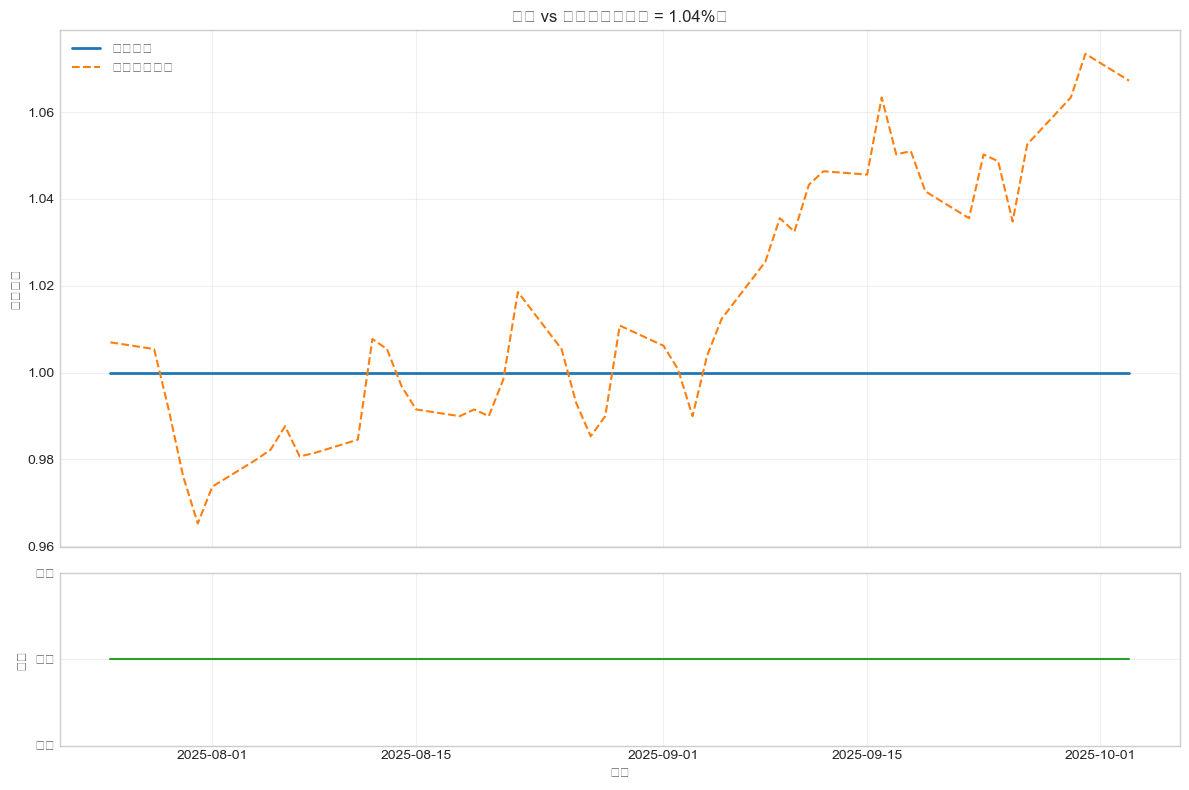

In [249]:
# %% [markdown]
# # Fixed-window LSTM 多类别分类：显著涨跌识别 + 策略回测
# 
# - 目标：用固定窗口交叉验证训练多类别 LSTM，对次日**显著上涨 / 显著下跌 / 无显著波动**进行分类预测。
# - 阈值搜索：在候选阈值集合中自动寻找达到 65%~70% 准确率的阈值。
# - 交易策略：按预测信号买入“显著上涨”ETF、卖出（做空）“显著下跌”ETF，输出回测表现。

# %% [markdown]
# ## 1. 环境与依赖

# %%
import warnings
warnings.filterwarnings("ignore")

import os, sys, math, random, copy
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid') if 'seaborn-v0_8-whitegrid' in plt.style.available else plt.style.use('ggplot')
sns.set_palette("Set2")

import yfinance as yf

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 设备与随机种子
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Device:", device)

# %% [markdown]
# ## 2. 数据获取

# %%
def fetch_prices(ticker: str = "2800.HK", period: str = "1y", interval: str = "1d") -> pd.DataFrame:
    tk = yf.Ticker(ticker)
    df = tk.history(period=period, interval=interval, auto_adjust=True)
    if df is None or df.empty:
        end = pd.Timestamp.today().normalize()
        start = end - pd.Timedelta(days=3 * 370)
        df = tk.history(start=start, end=end, interval=interval, auto_adjust=True)
    if df is None or df.empty:
        raise RuntimeError(f"无法获取 {ticker} 数据。")
    df.index = pd.to_datetime(df.index).tz_localize(None)
    return df[["Open", "High", "Low", "Close", "Volume"]].copy()

TICKER = "2800.HK"
df_raw = fetch_prices(ticker=TICKER, period="1y", interval="1d")
print(f"数据范围: {df_raw.index.min().date()} ~ {df_raw.index.max().date()}, 共 {len(df_raw)} 根K线")
display(df_raw.tail())

# %% [markdown]
# ## 3. 特征工程（保留上一版指标，仅去除回归标签）

# %%
def calculate_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1 / period, adjust=False).mean()
    roll_down = down.ewm(alpha=1 / period, adjust=False).mean().replace(0, np.nan)
    rs = roll_up / roll_down
    return 100 - (100 / (1 + rs))

def calculate_macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def build_features(df: pd.DataFrame, horizon: int = 1, use_log_return: bool = True):
    close = df["Close"].copy()
    feat = pd.DataFrame(index=df.index)

    feat["ret_1d"] = close.pct_change(1)
    feat["ret_2d"] = close.pct_change(2)
    feat["ret_5d"] = close.pct_change(5)
    feat["ret_10d"] = close.pct_change(10)

    feat["vol_5d"] = feat["ret_1d"].rolling(5).std()
    feat["vol_10d"] = feat["ret_1d"].rolling(10).std()
    feat["vol_20d"] = feat["ret_1d"].rolling(20).std()

    sma_5 = close.rolling(5).mean()
    sma_10 = close.rolling(10).mean()
    sma_20 = close.rolling(20).mean()
    sma_50 = close.rolling(50).mean()

    feat["close_to_sma5"] = close.shift(1) / sma_5 - 1
    feat["close_to_sma10"] = close.shift(1) / sma_10 - 1
    feat["close_to_sma20"] = close.shift(1) / sma_20 - 1
    feat["sma5_sma10"] = sma_5 / sma_10 - 1
    feat["sma10_sma20"] = sma_10 / sma_20 - 1

    feat["rsi_14"] = calculate_rsi(close.shift(1), 14)
    macd_line, signal_line, histogram = calculate_macd(close.shift(1))
    feat["macd"] = macd_line
    feat["macd_signal"] = signal_line
    feat["macd_hist"] = histogram

    bb_period = 20
    bb_std = close.rolling(bb_period).std()
    bb_mean = close.rolling(bb_period).mean()
    feat["bb_upper"] = (bb_mean + 2 * bb_std - close.shift(1)) / close.shift(1)
    feat["bb_lower"] = (close.shift(1) - (bb_mean - 2 * bb_std)) / close.shift(1)

    if "Volume" in df.columns:
        feat["volume_ratio"] = df["Volume"] / df["Volume"].rolling(20).mean()
        feat["volume_change"] = df["Volume"].pct_change()

    feat["day_of_week"] = df.index.dayofweek
    feat["month"] = df.index.month
    feat["quarter"] = df.index.quarter

    for lag in [1, 2, 3, 5, 10]:
        feat[f"ret_lag_{lag}"] = feat["ret_1d"].shift(lag)

    if use_log_return:
        next_ret = np.log(close.shift(-horizon) / close)
    else:
        next_ret = close.pct_change(horizon).shift(-horizon)

    feat = feat.replace([np.inf, -np.inf], np.nan)
    data = feat.copy()
    data["next_return"] = next_ret

    data = data.dropna().copy()
    feature_cols = [c for c in data.columns if c != "next_return"]

    return data, feature_cols

feat_df, feature_cols = build_features(df_raw, horizon=1, use_log_return=True)
print(f"清洗后样本数: {len(feat_df)}, 特征数: {len(feature_cols)}")
display(feat_df.tail())

# %% [markdown]
# ## 4. 序列构建（lookback 窗）

# %%
def make_sequences(
    feat_df: pd.DataFrame,
    feature_cols: List[str],
    lookback: int,
    label_cols: List[str]
) -> Tuple[np.ndarray, Dict[str, np.ndarray], pd.DatetimeIndex]:
    X_2d = feat_df[feature_cols].astype(np.float32).values
    dates = feat_df.index
    N = len(feat_df)
    if N < lookback:
        raise ValueError(f"样本不足: N={N} < lookback={lookback}")

    X_list = []
    labels_dict = {col: [] for col in label_cols}
    idx_list = []

    for end in range(lookback - 1, N):
        start = end - lookback + 1
        X_list.append(X_2d[start:end + 1])
        idx_list.append(dates[end])
        for col in label_cols:
            labels_dict[col].append(feat_df.iloc[end][col])

    X_seq = np.stack(X_list).astype(np.float32)
    labels_dict = {col: np.asarray(vals) for col, vals in labels_dict.items()}
    seq_index = pd.DatetimeIndex(idx_list)
    return X_seq, labels_dict, seq_index

# %% [markdown]
# ## 5. 标签定义与阈值工具

# %%
CLASS_ID_DOWN = 0
CLASS_ID_NEUTRAL = 1
CLASS_ID_UP = 2
NUM_CLASSES = 3

def label_significant_moves(next_returns: pd.Series, threshold: float) -> pd.Series:
    if threshold <= 0:
        raise ValueError("threshold 必须为正数。")
    labels = pd.Series(
        np.full(len(next_returns), CLASS_ID_NEUTRAL, dtype=np.int32),
        index=next_returns.index
    )
    labels[next_returns >= threshold] = CLASS_ID_UP
    labels[next_returns <= -threshold] = CLASS_ID_DOWN
    return labels

# %% [markdown]
# ## 6. 标准化工具

# %%
def fit_scaler_3d(X_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    assert X_train.ndim == 3
    flat = X_train.reshape(-1, X_train.shape[-1])
    mean = flat.mean(axis=0)
    std = flat.std(axis=0)
    std = np.where(std < 1e-12, 1e-12, std)
    return mean.astype(np.float32), std.astype(np.float32)

def transform_3d(X: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (X - mean[None, None, :]) / std[None, None, :]

# %% [markdown]
# ## 7. LSTM 模型与训练封装（多类别）

# %%
class LSTMMultiClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden_size, NUM_CLASSES)

    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        h = self.dropout(h)
        h = self.act(self.fc1(h))
        logits = self.out(h)
        return logits

@dataclass
class TrainConfig:
    epochs: int = 120
    batch_size: int = 64
    patience: int = 15
    lr: float = 1e-3
    weight_decay: float = 1e-4
    lr_factor: float = 0.5
    lr_patience: int = 8
    lr_min: float = 1e-5
    grad_clip: float = 1.0
    verbose: bool = False

CFG = TrainConfig()

def make_loader_classification(X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool) -> DataLoader:
    X_t = torch.from_numpy(X.astype(np.float32))
    y_t = torch.from_numpy(y.astype(np.int64))
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=torch.cuda.is_available())

def train_classifier(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, cfg: TrainConfig) -> Tuple[nn.Module, Dict[str, List[float]]]:
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    try:
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min',
            factor=cfg.lr_factor, patience=cfg.lr_patience,
            min_lr=cfg.lr_min
        )
    except TypeError:
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min',
            factor=cfg.lr_factor, patience=cfg.lr_patience
        )

    best_state = copy.deepcopy(model.state_dict())
    best_val = float('inf')
    no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if cfg.verbose and (epoch % 10 == 0 or epoch == 1):
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f} | lr {cur_lr:.2e}")

        if val_loss + 1e-12 < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                if cfg.verbose:
                    print(f"Early stop at epoch {epoch}, best_val={best_val:.6f}")
                break

    model.load_state_dict(best_state)
    return model, history

def predict_logits(model: nn.Module, X: np.ndarray, batch_size: int = 256) -> np.ndarray:
    model = model.to(device)
    model.eval()
    outputs = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i + batch_size].astype(np.float32)).to(device)
            logits = model(xb)
            outputs.append(logits.cpu().numpy())
    return np.concatenate(outputs, axis=0)

def softmax_np(logits: np.ndarray) -> np.ndarray:
    logits = logits - logits.max(axis=1, keepdims=True)
    exp = np.exp(logits)
    return exp / exp.sum(axis=1, keepdims=True)

# %% [markdown]
# ## 8. 固定窗口交叉验证（多类别版本）

# %%
def fixed_window_cv_lstm_classifier(
    X_seq_all: np.ndarray,
    y_all: np.ndarray,
    returns_all: np.ndarray,
    seq_index: pd.DatetimeIndex,
    test_size: int,
    train_window: int,
    val_size: int,
    step_size: Optional[int],
    cfg: TrainConfig,
    collect_predictions: bool = False,
    verbose: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if step_size is None:
        step_size = test_size
    N = len(X_seq_all)
    if N < train_window + val_size + test_size:
        raise ValueError("样本长度不足以执行指定窗口。")

    metrics = []
    preds_list = []
    start_index = train_window + val_size
    fold_id = 0

    for test_start in range(start_index, N - test_size + 1, step_size):
        train_end = test_start
        val_start = train_end - val_size
        train_start = val_start - train_window
        test_end = test_start + test_size

        if train_start < 0:
            continue

        X_train = X_seq_all[train_start:val_start]
        y_train = y_all[train_start:val_start]
        X_val = X_seq_all[val_start:train_end]
        y_val = y_all[val_start:train_end]
        X_test = X_seq_all[test_start:test_end]
        y_test = y_all[test_start:test_end]
        r_test = returns_all[test_start:test_end]
        test_dates = seq_index[test_start:test_end]

        mean, std = fit_scaler_3d(X_train)
        X_train_sc = transform_3d(X_train, mean, std)
        X_val_sc = transform_3d(X_val, mean, std)
        X_test_sc = transform_3d(X_test, mean, std)

        train_loader = make_loader_classification(X_train_sc, y_train, cfg.batch_size, shuffle=True)
        val_loader = make_loader_classification(X_val_sc, y_val, cfg.batch_size, shuffle=False)

        model = LSTMMultiClassifier(input_size=X_train_sc.shape[-1], hidden_size=64, dropout=0.3)
        model, _ = train_classifier(model, train_loader, val_loader, cfg)

        logits_test = predict_logits(model, X_test_sc, batch_size=256)
        proba_test = softmax_np(logits_test)
        y_pred = proba_test.argmax(axis=1)

        acc = accuracy_score(y_test, y_pred)
        try:
            bacc = balanced_accuracy_score(y_test, y_pred)
        except Exception:
            bacc = np.nan
        macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

        fold_metrics = {
            "fold": fold_id,
            "acc": acc,
            "bacc": bacc,
            "macro_f1": macro_f1,
            "train_size": len(X_train_sc),
            "val_size": len(X_val_sc),
            "test_size": len(X_test_sc),
            "test_start": test_dates[0],
            "test_end": test_dates[-1],
        }
        metrics.append(fold_metrics)

        if collect_predictions:
            fold_pred = pd.DataFrame({
                "fold": fold_id,
                "date": test_dates,
                "actual_class": y_test,
                "pred_class": y_pred,
                "actual_return": r_test,
            })
            for cls in range(NUM_CLASSES):
                fold_pred[f"proba_{cls}"] = proba_test[:, cls]
            preds_list.append(fold_pred)

        fold_id += 1
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    metrics_df = pd.DataFrame(metrics)
    preds_df = pd.concat(preds_list, ignore_index=True) if (collect_predictions and preds_list) else pd.DataFrame()
    if verbose:
        print(f"共生成 {len(metrics_df)} 个折。")
    return metrics_df, preds_df

# %% [markdown]
# ## 9. 阈值扫描与选择

# %%
def run_threshold_search(
    feat_df: pd.DataFrame,
    feature_cols: List[str],
    lookback: int,
    thresholds: List[float],
    train_window: int,
    val_size: int,
    test_size: int,
    step_size: Optional[int],
    cfg: TrainConfig,
    min_class_count: int = 5,
) -> pd.DataFrame:
    records = []
    for thr in thresholds:
        labeled_df = feat_df.copy()
        labeled_df["target_class"] = label_significant_moves(labeled_df["next_return"], thr)

        class_counts = labeled_df["target_class"].value_counts()
        class_counts = class_counts.reindex([CLASS_ID_DOWN, CLASS_ID_NEUTRAL, CLASS_ID_UP], fill_value=0)
        if class_counts.min() < min_class_count:
            continue

        X_seq, labels_dict, seq_index = make_sequences(
            labeled_df,
            feature_cols=feature_cols,
            lookback=lookback,
            label_cols=["target_class", "next_return"]
        )
        y_all = labels_dict["target_class"].astype(np.int64)
        returns_all = labels_dict["next_return"].astype(np.float32)

        try:
            cv_metrics, _ = fixed_window_cv_lstm_classifier(
                X_seq, y_all, returns_all, seq_index,
                test_size=test_size,
                train_window=train_window,
                val_size=val_size,
                step_size=step_size,
                cfg=cfg,
                collect_predictions=False,
                verbose=False
            )
        except ValueError:
            continue

        if cv_metrics.empty:
            continue

        record = {
            "threshold": thr,
            "mean_acc": cv_metrics["acc"].mean(),
            "std_acc": cv_metrics["acc"].std(ddof=0),
            "mean_bacc": cv_metrics["bacc"].mean(),
            "mean_macro_f1": cv_metrics["macro_f1"].mean(),
            "folds": len(cv_metrics)
        }
        records.append(record)

    results_df = pd.DataFrame(records)
    if not results_df.empty:
        results_df = results_df.sort_values("mean_acc", ascending=False).reset_index(drop=True)
    return results_df

def select_best_threshold(results_df: pd.DataFrame, desired_acc_range: Tuple[float, float] = (0.65, 0.70)) -> pd.Series:
    if results_df.empty:
        raise ValueError("阈值搜索无可用结果，请调整阈值范围或窗口参数。")
    lower, upper = desired_acc_range
    in_range = results_df[(results_df["mean_acc"] >= lower) & (results_df["mean_acc"] <= upper)]
    if not in_range.empty:
        best = in_range.sort_values(["mean_macro_f1", "mean_acc"], ascending=False).iloc[0]
    else:
        center = (lower + upper) / 2
        best = results_df.iloc[(results_df["mean_acc"] - center).abs().argsort()].iloc[0]
    return best

# %% [markdown]
# ## 10. 分类结果汇总工具

# %%
def summarize_classification(preds_df: pd.DataFrame, class_names: List[str]) -> Dict[str, object]:
    y_true = preds_df["actual_class"].astype(int).values
    y_pred = preds_df["pred_class"].astype(int).values

    overall = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0)
    }
    report = classification_report(
        y_true, y_pred,
        labels=[CLASS_ID_DOWN, CLASS_ID_NEUTRAL, CLASS_ID_UP],
        target_names=class_names,
        digits=3,
        zero_division=0
    )
    conf = confusion_matrix(
        y_true, y_pred,
        labels=[CLASS_ID_DOWN, CLASS_ID_NEUTRAL, CLASS_ID_UP]
    )
    conf_df = pd.DataFrame(conf, index=class_names, columns=class_names)

    overall["classification_report"] = report
    overall["confusion_matrix"] = conf_df
    return overall

# %% [markdown]
# ## 11. 交易策略模拟（显著上涨做多 / 显著下跌做空）

# %%
def simulate_significant_strategy(
    preds_df: pd.DataFrame,
    transaction_cost_bp: float = 2.0,
    class_up: int = CLASS_ID_UP,
    class_down: int = CLASS_ID_DOWN,
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    if preds_df.empty:
        raise ValueError("预测结果为空，无法回测策略。")

    df = preds_df.sort_values("date").copy()
    df["position"] = 0
    df.loc[df["pred_class"] == class_up, "position"] = 1
    df.loc[df["pred_class"] == class_down, "position"] = -1

    df["simple_return"] = np.exp(df["actual_return"]) - 1.0
    df["strategy_simple_return"] = df["position"] * df["simple_return"]

    position_change = df["position"].diff().abs()
    position_change.iloc[0] = abs(df["position"].iloc[0])
    cost_rate = transaction_cost_bp / 10000.0
    df["transaction_cost"] = position_change * cost_rate
    df["strategy_simple_return_after_cost"] = df["strategy_simple_return"] - df["transaction_cost"]

    df["strategy_equity"] = (1 + df["strategy_simple_return_after_cost"]).cumprod()
    df["buyhold_equity"] = (1 + df["simple_return"]).cumprod()

    df["strategy_equity"] = df["strategy_equity"].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")
    df["buyhold_equity"] = df["buyhold_equity"].replace([np.inf, -np.inf], np.nan).fillna(method="ffill")

    stats: Dict[str, object] = {}
    total_days = len(df)
    if total_days == 0:
        raise ValueError("无交易样本。")

    strategy_final = df["strategy_equity"].iloc[-1]
    buyhold_final = df["buyhold_equity"].iloc[-1]
    stats["total_return"] = strategy_final - 1
    stats["buyhold_total_return"] = buyhold_final - 1

    years = max(total_days / 252, 1 / 252)
    stats["annualized_return"] = strategy_final ** (1 / years) - 1
    stats["buyhold_annual_return"] = buyhold_final ** (1 / years) - 1

    daily_mean = df["strategy_simple_return_after_cost"].mean()
    daily_std = df["strategy_simple_return_after_cost"].std()
    stats["annualized_volatility"] = daily_std * np.sqrt(252)
    stats["sharpe_ratio"] = (daily_mean / daily_std) * np.sqrt(252) if daily_std > 1e-8 else np.nan

    cum_max = df["strategy_equity"].cummax()
    drawdown = df["strategy_equity"] / cum_max - 1
    stats["max_drawdown"] = drawdown.min()

    trade_mask = df["position"] != 0
    if trade_mask.any():
        stats["hit_rate_on_trades"] = (df.loc[trade_mask, "actual_class"] == df.loc[trade_mask, "pred_class"]).mean()
        stats["avg_trade_return"] = df.loc[trade_mask, "strategy_simple_return_after_cost"].mean()
        stats["num_trading_days"] = int(trade_mask.sum())
    else:
        stats["hit_rate_on_trades"] = np.nan
        stats["avg_trade_return"] = np.nan
        stats["num_trading_days"] = 0

    pos_dist = df["position"].value_counts(normalize=True).sort_index()
    stats["position_distribution"] = {
        "short_pct": pos_dist.get(-1, 0.0),
        "flat_pct": pos_dist.get(0, 0.0),
        "long_pct": pos_dist.get(1, 0.0),
    }
    stats["transaction_cost_bp"] = transaction_cost_bp

    return df, stats

def plot_equity_curves(sim_df: pd.DataFrame, threshold: float, class_names: List[str]):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]})

    ax_price = axes[0]
    ax_pos = axes[1]

    ax_price.plot(sim_df["date"], sim_df["strategy_equity"], label="策略权益", color="tab:blue", linewidth=2)
    ax_price.plot(sim_df["date"], sim_df["buyhold_equity"], label="买入持有权益", color="tab:orange", linestyle="--")
    ax_price.set_ylabel("累计净值")
    ax_price.set_title(f"策略 vs 买入持有（阈值 = {threshold:.2%}）")
    ax_price.legend(loc="best")
    ax_price.grid(True, alpha=0.3)

    ax_pos.step(sim_df["date"], sim_df["position"], where="post", color="tab:green", linewidth=1.5)
    ax_pos.set_ylabel("仓位")
    ax_pos.set_xlabel("日期")
    ax_pos.set_yticks([-1, 0, 1])
    ax_pos.set_yticklabels(["做空", "空仓", "做多"])
    ax_pos.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 12. 参数设定与阈值搜索

# %%
LOOKBACK = 14
TRAIN_WINDOW = 150
VAL_SIZE = 10
TEST_SIZE = 7
STEP_SIZE = 7
THRESHOLD_GRID = np.round(np.linspace(0.004, 0.018, 12), 4)  # 0.4% ~ 1.8%

threshold_results = run_threshold_search(
    feat_df=feat_df,
    feature_cols=feature_cols,
    lookback=LOOKBACK,
    thresholds=THRESHOLD_GRID.tolist(),
    train_window=TRAIN_WINDOW,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE,
    step_size=STEP_SIZE,
    cfg=CFG,
    min_class_count=5,
)

print("阈值搜索结果（按准确率排序）:")
display(threshold_results)

best_threshold_info = select_best_threshold(threshold_results, desired_acc_range=(0.65, 0.70))
best_threshold = float(best_threshold_info["threshold"])
print(f"\n选定阈值: {best_threshold:.2%}")
print(best_threshold_info)

# %% [markdown]
# ## 13. 使用最佳阈值重新训练并收集 OOF 预测

# %%
feat_df_best = feat_df.copy()
feat_df_best["target_class"] = label_significant_moves(feat_df_best["next_return"], best_threshold)

X_seq_best, label_dict_best, seq_index_best = make_sequences(
    feat_df_best,
    feature_cols=feature_cols,
    lookback=LOOKBACK,
    label_cols=["target_class", "next_return"]
)

y_best = label_dict_best["target_class"].astype(np.int64)
returns_best = label_dict_best["next_return"].astype(np.float32)

cv_metrics, cv_preds = fixed_window_cv_lstm_classifier(
    X_seq_best, y_best, returns_best, seq_index_best,
    test_size=TEST_SIZE,
    train_window=TRAIN_WINDOW,
    val_size=VAL_SIZE,
    step_size=STEP_SIZE,
    cfg=CFG,
    collect_predictions=True,
    verbose=True
)

print("交叉验证折指标（前 5 行）:")
display(cv_metrics.head())

summary_table = cv_metrics[["acc", "bacc", "macro_f1"]].agg(["mean", "std", "min", "max"])
print("\n交叉验证指标汇总:")
display(summary_table)

# %% [markdown]
# ## 14. 分类表现汇总

# %%
class_names = [
    f"显著下跌 (≤ -{best_threshold:.2%})",
    "无显著波动",
    f"显著上涨 (≥ {best_threshold:.2%})",
]

classification_summary = summarize_classification(cv_preds, class_names)
print("整体准确率:", f"{classification_summary['accuracy']:.3f}")
print("整体平衡准确率:", f"{classification_summary['balanced_accuracy']:.3f}")
print("Macro-F1:", f"{classification_summary['macro_f1']:.3f}")
print("\n分类报告:")
print(classification_summary["classification_report"])
print("混淆矩阵:")
display(classification_summary["confusion_matrix"])

# %% [markdown]
# ## 15. 策略回测

# %%
TRANSACTION_COST_BP = 2.0  # 默认双边 2 bps
sim_df, perf_stats = simulate_significant_strategy(
    cv_preds,
    transaction_cost_bp=TRANSACTION_COST_BP,
    class_up=CLASS_ID_UP,
    class_down=CLASS_ID_DOWN
)

print("策略样本预览:")
display(sim_df.head())

print("\n策略表现指标:")
perf_table = pd.DataFrame([{
    "总收益": perf_stats["total_return"],
    "买入持有总收益": perf_stats["buyhold_total_return"],
    "年化收益率": perf_stats["annualized_return"],
    "买入持有年化收益率": perf_stats["buyhold_annual_return"],
    "年化波动率": perf_stats["annualized_volatility"],
    "夏普率": perf_stats["sharpe_ratio"],
    "最大回撤": perf_stats["max_drawdown"],
    "交易日数": perf_stats["num_trading_days"],
    "交易准确率": perf_stats["hit_rate_on_trades"],
    "单次交易平均收益": perf_stats["avg_trade_return"],
    "多头占比": perf_stats["position_distribution"]["long_pct"],
    "空头占比": perf_stats["position_distribution"]["short_pct"],
    "空仓占比": perf_stats["position_distribution"]["flat_pct"],
    "交易成本 (bps)": perf_stats["transaction_cost_bp"],
}])
display(perf_table.T.rename(columns={0: "值"}))

plot_equity_curves(sim_df, threshold=best_threshold, class_names=class_names)